# Feature Extraction Layer

## **Description:**

- Create a simpe feature extraction step
- No extensive modeling or feature extraction is required, we need just to ensure our modeling step is trustworthy:
    - We don't have any target leakage

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
import scripts.feature_extr as feature_extr # feature_extr.py module

import warnings
warnings.filterwarnings('ignore')

## Load and transform train, aggregated train and test datasets

In [2]:
train_df = pd.read_csv('../data/merged_train.csv')
aggregated_train_df = pd.read_csv('../data/merged_train_aggregated.csv')
test_df = pd.read_csv('../data/merged_test.csv')

aggregated_train_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,shop_name
0,0,2,27,1,2499.0,0,0,"007 Legends [PS3, русская версия]",19,Игры - PS3,"Адыгея ТЦ ""Мега"""
1,0,2,33,1,499.0,0,0,1+1 (BD),37,Кино - Blu-Ray,"Адыгея ТЦ ""Мега"""
2,0,2,317,1,299.0,0,0,1С:Аудиокниги. Мединский В. Мифы о России. О р...,45,Книги - Аудиокниги 1С,"Адыгея ТЦ ""Мега"""


In [3]:
train_df['date'] = pd.to_datetime(train_df['date'])

int_columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_day', 'month', 'year', 'item_category_id']
float_columns = ['item_price']
object_columns = ['item_name', 'item_category_name', 'shop_name']

train_df = feature_extr.transform_df_types(train_df, int_columns, float_columns, object_columns)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935848 entries, 0 to 2935847
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int32         
 2   shop_id             int32         
 3   item_id             int32         
 4   item_price          float32       
 5   item_cnt_day        int32         
 6   month               int32         
 7   year                int32         
 8   item_name           category      
 9   item_category_id    int32         
 10  item_category_name  category      
 11  shop_name           category      
dtypes: category(3), datetime64[ns](1), float32(1), int32(7)
memory usage: 123.9 MB


In [4]:
int_columns = ['date_block_num', 'shop_id', 'item_id', 'month', 'year', 'item_category_id']
float_columns = ['item_price', 'item_cnt_month']
object_columns = ['item_name', 'item_category_name', 'shop_name']

aggregated_train_df = feature_extr.transform_df_types(aggregated_train_df, int_columns, float_columns, object_columns)
aggregated_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   date_block_num      1608724 non-null  int32   
 1   shop_id             1608724 non-null  int32   
 2   item_id             1608724 non-null  int32   
 3   item_cnt_month      1608724 non-null  float32 
 4   item_price          1608724 non-null  float32 
 5   month               1608724 non-null  int32   
 6   year                1608724 non-null  int32   
 7   item_name           1608724 non-null  category
 8   item_category_id    1608724 non-null  int32   
 9   item_category_name  1608724 non-null  category
 10  shop_name           1608724 non-null  category
dtypes: category(3), float32(2), int32(6)
memory usage: 55.9 MB


In [5]:
int_columns = ['ID', 'shop_id', 'item_id', 'item_category_id']
object_columns = ['item_name', 'item_category_name', 'shop_name']

test_df = feature_extr.transform_df_types(test_df, int_columns, object_columns=object_columns)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   ID                  214200 non-null  int32   
 1   shop_id             214200 non-null  int32   
 2   item_id             214200 non-null  int32   
 3   item_name           214200 non-null  category
 4   item_category_id    214200 non-null  int32   
 5   item_category_name  214200 non-null  category
 6   shop_name           214200 non-null  category
dtypes: category(3), int32(4)
memory usage: 4.3 MB


## Add **"months since the last sale for each item, shop and date_block_num"** feature

### 1. Sort dataframe

In [6]:
# aggregated_sorted = aggregated_train_df.sort_values(by=['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True)

# aggregated_sorted['months_since_last_sale'] = -1

# for row in aggregated_sorted.itertuples():
#     if row.Index == 0: 
#         continue
    
#     row_prev = aggregated_sorted.iloc[row.Index - 1]
#     if row_prev['shop_id'] == row.shop_id and row_prev['item_id'] == row.item_id:
#         aggregated_sorted.at[row.Index, 'months_since_last_sale'] = row.date_block_num - row_prev['date_block_num']

# aggregated_sorted.to_csv('../data/aggregated_months.csv', index=False)

In [7]:
aggregated_sorted = pd.read_csv('../data/aggregated_months.csv')

int_columns = ['date_block_num', 'shop_id', 'item_id', 'month', 'year', 'item_category_id', 'months_since_last_sale']
float_columns = ['item_price', 'item_cnt_month']
object_columns = ['item_name', 'item_category_name', 'shop_name']

aggregated_train_df = feature_extr.transform_df_types(aggregated_sorted, int_columns, float_columns, object_columns)
aggregated_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608724 entries, 0 to 1608723
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   date_block_num          1608724 non-null  int32   
 1   shop_id                 1608724 non-null  int32   
 2   item_id                 1608724 non-null  int32   
 3   item_cnt_month          1608724 non-null  float32 
 4   item_price              1608724 non-null  float32 
 5   month                   1608724 non-null  int32   
 6   year                    1608724 non-null  int32   
 7   item_name               1608724 non-null  category
 8   item_category_id        1608724 non-null  int32   
 9   item_category_name      1608724 non-null  category
 10  shop_name               1608724 non-null  category
 11  months_since_last_sale  1608724 non-null  int32   
dtypes: category(3), float32(2), int32(7)
memory usage: 62.0 MB


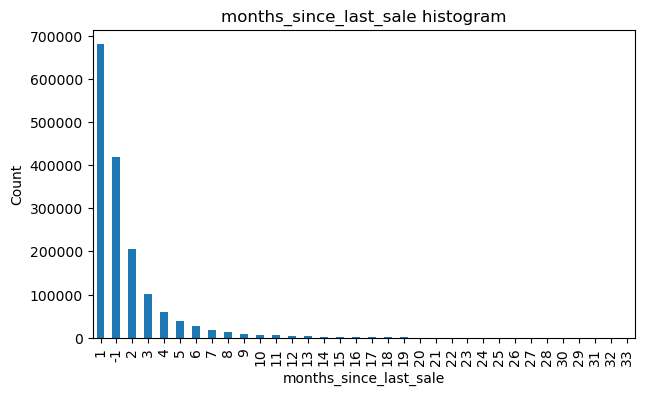

In [8]:
aggregated_train_df['months_since_last_sale'].value_counts().plot(kind='bar', figsize=(7, 4), ylabel='Count', xlabel='months_since_last_sale', title='months_since_last_sale histogram');

Looks like the **months_since_last_sale** feature was calculated properly

### Add **months_since_last_sale** feature to the test dataframe

In [9]:
# train_subdf = aggregated_train_df.copy()[['date_block_num', 'shop_id', 'item_id', 'months_since_last_sale']]
# train_subdf['is_test'] = 0

# test_subdf = test_df[['shop_id', 'item_id']]
# test_subdf['is_test'] = 1
# test_subdf['date_block_num'] = 34
# test_subdf['months_since_last_sale'] = -1

# united_subdf = pd.concat([train_subdf, test_subdf])

In [10]:
# united_subdf_sorted = united_subdf.sort_values(by=['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True)

# for row in united_subdf_sorted.itertuples():
#     if row.Index == 0 or row.is_test == 0: 
#         continue
    
#     row_prev = united_subdf_sorted.iloc[row.Index - 1]
#     if row_prev['shop_id'] == row.shop_id and row_prev['item_id'] == row.item_id:
#         united_subdf_sorted.at[row.Index, 'months_since_last_sale'] = row.date_block_num - row_prev['date_block_num']

# test_df['is_test'] = 1
# test_df = test_df.merge(united_subdf_sorted, on=['shop_id', 'item_id', 'is_test'], how='left')

# test_df.drop(columns=['is_test', 'date_block_num'], inplace=True)
# test_df.to_csv('../data/test_months.csv', index=False)

In [12]:
test_df = pd.read_csv('../data/test_months.csv')
test_df.isna().sum().sum()

0

In [13]:
int_columns = ['ID', 'shop_id', 'item_id', 'item_category_id', 'months_since_last_sale']
object_columns = ['item_name', 'item_category_name', 'shop_name']

test_df = feature_extr.transform_df_types(test_df, int_columns, object_columns=object_columns)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214284 entries, 0 to 214283
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   ID                      214284 non-null  int32   
 1   shop_id                 214284 non-null  int32   
 2   item_id                 214284 non-null  int32   
 3   item_name               214284 non-null  category
 4   item_category_id        214284 non-null  int32   
 5   item_category_name      214284 non-null  category
 6   shop_name               214284 non-null  category
 7   months_since_last_sale  214284 non-null  int32   
dtypes: category(3), int32(5)
memory usage: 5.1 MB


## Add **revenue** lag features

### Calculate revenue

In [14]:
train_df['revenue'] = train_df['item_price'] * train_df['item_cnt_day']
train_aggregated = train_df.groupby(['date_block_num', 'shop_id']).agg({'revenue': 'sum'}).reset_index()

aggregated_train_df = aggregated_train_df.merge(train_aggregated, on=['date_block_num', 'shop_id'], how='left')

In [15]:
aggregated_train_df.isna().sum().sum()

0

### Add revenue information for each **date_block_num** and **shop_id** for lags = [1, 2, 3, 6, 12]

In [16]:
aggregated_lagged = feature_extr.train_add_lag_features(aggregated_train_df, 'revenue', on_columns=['shop_id', 'date_block_num'], operation='mean', lags=[1, 2, 3, 6, 12])

In [17]:
aggregated_lagged[aggregated_lagged['date_block_num'] == 20].head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue,revenue_lag_1,revenue_lag_2,revenue_lag_3,revenue_lag_6,revenue_lag_12
14,20,2,32,2.0,149.0,8,1,1+1,40,Кино - DVD,"Адыгея ТЦ ""Мега""",2,1473540.0,1194669.0,1102918.5,1263924.0,1889424.0,1321185.0
23,20,2,33,1.0,199.0,8,1,1+1 (BD),37,Кино - Blu-Ray,"Адыгея ТЦ ""Мега""",8,1473540.0,1194669.0,1102918.5,1263924.0,1889424.0,1321185.0
71,20,2,482,2.0,3300.0,8,1,1С:Бухгалтерия 8. Базовая версия,73,Программы - 1С:Предприятие 8,"Адыгея ТЦ ""Мега""",2,1473540.0,1194669.0,1102918.5,1263924.0,1889424.0,1321185.0


### Do this for **test** dataframe as well

In [18]:
test_lagged = feature_extr.test_add_lag_features(test_df, aggregated_train_df, col='revenue', on_columns=['shop_id'], lags=[1, 2, 3, 6, 12])

In [19]:
test_lagged.head()

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_lag_1,revenue_lag_2,revenue_lag_3,revenue_lag_6,revenue_lag_12
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1100220.0,1171450.0,1160948.5,1036892.0,1750290.0
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",-1,1100220.0,1171450.0,1160948.5,1036892.0,1750290.0
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1100220.0,1171450.0,1160948.5,1036892.0,1750290.0
3,3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",3,1100220.0,1171450.0,1160948.5,1036892.0,1750290.0
4,4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",-1,1100220.0,1171450.0,1160948.5,1036892.0,1750290.0


## Add **target (item_cnt_month)** lag features for lags = [1, 2, 3, 6, 12]

In [20]:
aggregated_lagged = feature_extr.train_add_lag_features(aggregated_lagged, 'item_cnt_month', on_columns=['item_id', 'shop_id', 'date_block_num'], lags=[1, 2, 3, 6, 12])

In [21]:
aggregated_lagged[aggregated_lagged['date_block_num'] == 20].head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,revenue_lag_1,revenue_lag_2,revenue_lag_3,revenue_lag_6,revenue_lag_12,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
14,20,2,32,2.0,149.0,8,1,1+1,40,Кино - DVD,...,1194669.0,1102918.5,1263924.0,1889424.0,1321185.0,0.0,1.0,0.0,1.0,0.0
23,20,2,33,1.0,199.0,8,1,1+1 (BD),37,Кино - Blu-Ray,...,1194669.0,1102918.5,1263924.0,1889424.0,1321185.0,0.0,0.0,0.0,0.0,0.0
71,20,2,482,2.0,3300.0,8,1,1С:Бухгалтерия 8. Базовая версия,73,Программы - 1С:Предприятие 8,...,1194669.0,1102918.5,1263924.0,1889424.0,1321185.0,0.0,1.0,0.0,0.0,2.0


### Do this for **test** dataframe as well

In [22]:
test_lagged = feature_extr.test_add_lag_features(test_lagged, aggregated_train_df, col='item_cnt_month', on_columns=['item_id', 'shop_id'], lags=[1, 2, 3, 6, 12])

In [23]:
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_lag_1,revenue_lag_2,revenue_lag_3,revenue_lag_6,revenue_lag_12,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1100220.0,1171450.0,1160948.5,1036892.0,1750290.0,0.0,1.0,3.0,1.0,1.0
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",-1,1100220.0,1171450.0,1160948.5,1036892.0,1750290.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1100220.0,1171450.0,1160948.5,1036892.0,1750290.0,1.0,3.0,1.0,3.0,0.0


## Add **month, year** features to the **test_lagged** dataframe

In [24]:
aggregated_lagged[aggregated_lagged['date_block_num'] == 33].head(1)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,revenue_lag_1,revenue_lag_2,revenue_lag_3,revenue_lag_6,revenue_lag_12,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
10,33,2,31,1.0,399.0,9,2,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,...,1337915.0,986144.0,986791.0,1270588.0,1434694.0,0.0,0.0,0.0,0.0,0.0


### We can see, that the **test** dataset covers the period with **year=2** and **month=10**

In [25]:
test_lagged['month'] = 10
test_lagged['year'] = 2

In [26]:
aggregated_lagged['month'].unique()

array([ 0,  5,  2,  3,  4,  1,  9,  6,  8, 11,  7, 10], dtype=int32)

## Add **"number of days in the month"** feature

In [27]:
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
aggregated_lagged['days'] = aggregated_lagged['month'].map(days)
test_lagged['days'] = test_lagged['month'].map(days)

In [28]:
aggregated_lagged.isna().sum().sum()

0

In [29]:
test_lagged.isna().sum().sum()

0

## Add **"item_price"** lag features

### I will calculate average item price for each item and month across all shops

In [30]:
avg_item_price = aggregated_lagged.groupby(['item_id', 'date_block_num'])['item_price'].mean().reset_index()

avg_item_price.columns = ['item_id', 'date_block_num', 'avg_item_price']

In [31]:
aggregated_lagged = aggregated_lagged.merge(avg_item_price, on=['item_id', 'date_block_num'], how='left')
aggregated_lagged.isna().sum().sum()

0

In [32]:
aggregated_lagged = feature_extr.train_add_lag_features(aggregated_lagged, 'avg_item_price', on_columns=['item_id', 'date_block_num'], lags=[1, 2, 3, 4, 5, 6])

In [33]:
aggregated_lagged.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,month,year,item_name,item_category_id,item_category_name,...,item_cnt_month_lag_6,item_cnt_month_lag_12,days,avg_item_price,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_5,avg_item_price_lag_6
0,0,2,27,1.0,2499.0,0,0,"007 Legends [PS3, русская версия]",19,Игры - PS3,...,0.0,0.0,31,2325.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,17,2,27,1.0,498.0,5,1,"007 Legends [PS3, русская версия]",19,Игры - PS3,...,0.0,0.0,30,498.000000,498.000000,0.0,998.0,0.0,998.0,1048.0
2,2,2,30,1.0,359.0,2,0,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,Кино - DVD,...,0.0,0.0,31,388.716522,382.645966,0.0,0.0,0.0,0.0,0.0


### Do the same for the **test** dataframe

In [34]:
test_lagged = feature_extr.test_add_lag_features(test_lagged, aggregated_lagged, col='avg_item_price', on_columns=['item_id'], lags=[1, 2, 3, 4, 5, 6])

In [35]:
test_lagged.head(3)

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,months_since_last_sale,revenue_lag_1,revenue_lag_2,...,item_cnt_month_lag_12,month,year,days,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_5,avg_item_price_lag_6
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",2,1100220.0,1171450.0,...,1.0,10,2,30,1499.0,930.941772,918.377258,1485.070068,1346.308105,1512.057617
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",-1,1100220.0,1171450.0,...,0.0,10,2,30,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",1,1100220.0,1171450.0,...,0.0,10,2,30,1199.0,702.593750,698.031372,1198.991699,656.301819,779.121460


## Difference in columns sets

In [36]:
train_set = set(aggregated_lagged.columns.to_list())
test_set = set(test_lagged.columns.to_list())

train_set - test_set

{'avg_item_price', 'date_block_num', 'item_cnt_month', 'item_price', 'revenue'}

## Save transformed dataframes to .csv files

In [37]:
aggregated_lagged.to_csv('../data/result_train.csv', index=False)
test_lagged.to_csv('../data/result_test.csv', index=False)

## **Conclusion:**

- added **item_cnt_month** lag features
- added **revenue** lag features
- added **months_since_last_sale** lag features
- added **avg_item_price** for each (item, month) pair lag features
- added **days** (num of days in a month) feature
- created **days, months** features in the test dataset